"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[183 431]
[   0  183  431 1000]
(10, 3)
(10, 1000)
(10, 1000)


Text(0, 0.5, 'Firing Rate')

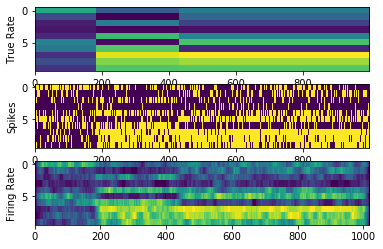

In [4]:
# Some poisson spiking
length = 1000
states = 3
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

nrns = 10
true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
print(true_lambda.shape)

true_r = np.zeros((nrns,length))
print(true_r.shape)
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
data_vec = np.random.random((nrns,length)) < true_r
convolved_data = np.array([np.convolve(x,np.ones(20)) for x in data_vec])
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)3
fig,ax = plt.subplots(3,1)
ax[0].imshow(true_r,aspect='auto')
#ax[0].set_ylim(0,1)
ax[1].imshow(data_vec,aspect='auto')
ax[2].imshow(convolved_data,aspect='auto')
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")
ax[2].set_ylabel("Firing Rate")

In [5]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [8]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)])
mean_vals.shape

(3, 10)

In [7]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = states,
                                  testval = mean_vals)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)

    # K = 5
    # alpha = pm.Gamma("alpha", 1, 1.0)
    # beta = pm.Beta("beta", 1.0, alpha, shape=K)
    # tau_latent = pm.Deterministic("tau_latent", stick_breaking(beta))
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

ValueError: operands could not be broadcast together with shapes (3,) (3,10) 

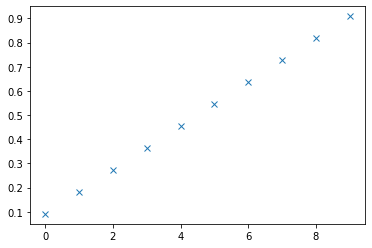

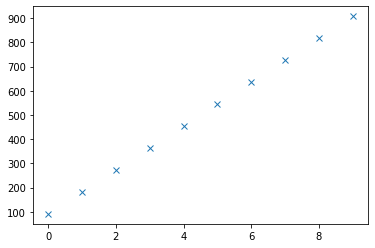

In [896]:
plt.plot(tau_latent.tag.test_value,'x')
plt.figure()
plt.plot(tau.tag.test_value,'x')

In [897]:
#idx[:,np.newaxis] - tau.tag.test_value[np.newaxis,:]

## NOTE :: tt.nnet.sigmoid implements sigmoid with no adjustable parameters
##      Please consider width of sigmoid in relation to number of bins when using
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])

In [898]:
# test_weight_stack = weight_stack.tag.test_value.copy()
# print(test_weight_stack.shape)
# test_weight_stack = np.append(np.ones((1,length)), test_weight_stack, axis=0)
# plt.imshow(test_weight_stack,aspect='auto')
# print(test_weight_stack.shape)

In [899]:
# inverse_weight_stack = 1 - test_weight_stack[1:]
# inverse_weight_stack = np.append(inverse_weight_stack, np.ones((1,length)), axis=0)
# plt.imshow(inverse_weight_stack,aspect='auto')
# print(inverse_weight_stack.shape)

In [900]:
# test_weight_stack = np.multiply(test_weight_stack,inverse_weight_stack)
# test_weight_stack.shape
# plt.imshow(test_weight_stack,aspect='auto')

In [901]:
# print((1-weight_stack[0][np.newaxis,:].tag.test_value).shape)
# print(weight_stack.tag.test_value.shape)
# print(weight_stack[0].tag.test_value.shape)

In [902]:
with model:
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)

In [903]:
with model:
    #weight_stack = pm.math.stack([1-weight_stack[0][np.newaxis,:],weight_stack], axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [904]:
with model:
    lambda_ = pm.math.sum(np.multiply(weight_stack[:states],lambda_latent[:,np.newaxis]),axis=0)

(1000,)


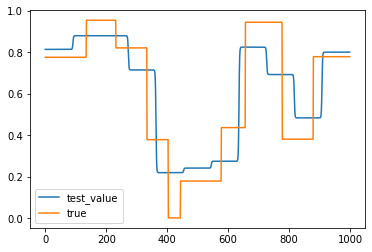

In [906]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(true_r,label='true')
plt.legend()
print(lambda_.tag.test_value.shape)

In [907]:
with model:


    # Sigmoing to create transitions based off tau
    # Hardcoded 3-5 states

    #     weight_stack = tt.nnet.sigmoid(idx[:,np.newaxis]-tau[np.newaxis,:])
    #     weight_stack = np.append(1-weight_stack[0][np.newaxis,:],weight_stack, axis=0)
    #     inverse_stack = 1 - weight_stack[2:]
    #     weight_stack[1:-1] = np.multiply(weight_stack[1:-1],inverse_stack)
    
    # weight_1_stack = tt.nnet.sigmoid(idx - tau[0])
    # if states > 2:
    #     weight_2_stack = tt.nnet.sigmoid(idx - tau[1])
    # if states > 3:
    #     weight_3_stack = tt.nnet.sigmoid(idx - tau[2])
    # if states > 4:
    #     weight_4_stack = tt.nnet.sigmoid(idx - tau[3])

    # # Generate firing rates from lambda and sigmoid weights
    # if states == 2:
    #     # 3 states
    #     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0]) + \
    #             np.multiply(weight_1_stack, lambda_latent[1])


    # if states == 3:
    #     # 3 states
    #     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0]) + \
    #             np.multiply(weight_1_stack * (1 - weight_2_stack), 
    #                     lambda_latent[1]) + \
    #             np.multiply(weight_2_stack, 
    #                         lambda_latent[2])

    # elif states == 4:
    #     # 4 states
    #     lambda_ = np.multiply(1 - weight_1_stack, 
    #                     lambda_latent[0]) + \
    #             np.multiply(weight_1_stack * (1 - weight_2_stack), 
    #                     lambda_latent[1]) + \
    #             np.multiply(weight_2_stack * (1 - weight_3_stack), 
    #                     lambda_latent[2]) + \
    #             np.multiply(weight_3_stack, 
    #                         lambda_latent[3])

    # elif states == 5:
    #     # 5 states
    #     lambda_ = np.multiply(1 - weight_1_stack, 
    #                     lambda_latent[0]) + \
    #             np.multiply(weight_1_stack * (1 - weight_2_stack), 
    #                     lambda_latent[1]) + \
    #             np.multiply(weight_2_stack * (1 - weight_3_stack), 
    #                     lambda_latent[2]) +\
    #             np.multiply(weight_3_stack * (1 - weight_4_stack), 
    #                     lambda_latent[3])+ \
    #             np.multiply(weight_4_stack, 
    #                     lambda_latent[4])

    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

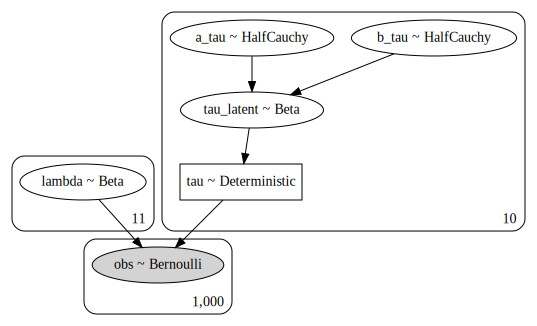

In [908]:
pm.model_to_graphviz(model)

In [909]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

Average Loss = 546.83: 100%|██████████| 100000/100000 [00:47<00:00, 2090.78it/s]
Finished [100%]: Average Loss = 546.8
INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.10-64/lock_dir/lock


In [910]:
# pm.traceplot(trace);

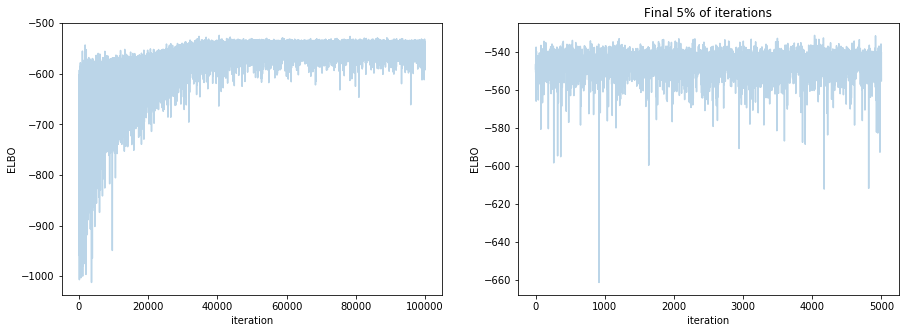

In [911]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [912]:
# ppc_list = [pm.sample_posterior_predictive(this_fit[1], samples = 2000, model = this_model) \
# #ppc_list = [pm.sample_posterior_predictive(this_fit, samples = 2000, model = this_model) \
#             for this_fit, this_model in zip(fit_list,model_list)]
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:01<00:00, 1152.95it/s]


Text(0.5, 1.0, 'Mean prediction')

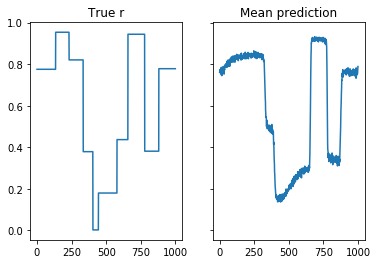

In [913]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')
#plt.legend()
#fig.savefig(f'{states}_state_ppc')

In [919]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
#tau_list = [this_fit['tau'] for this_fit in fit_list]
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(2000, 10)


array([ 41, 328, 390, 394, 501, 533, 655, 777, 834, 875])

(0, 1000)

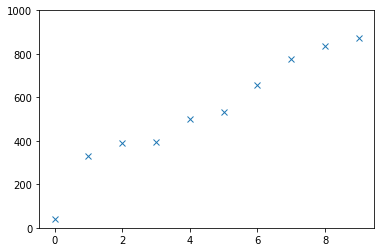

In [920]:
plt.plot(mode_tau,'x')
plt.ylim([0,length])

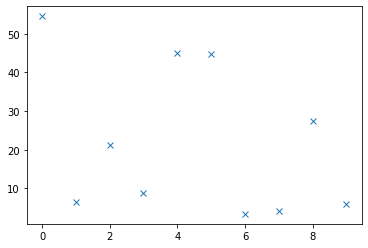

In [921]:
# Plot variances for each tau distribution
plt.plot(np.std(tau,axis=0),'x');

In [922]:
# max_val = 11
# tau = tau[:,:max_val]
# mode_tau = mode_tau[:max_val]

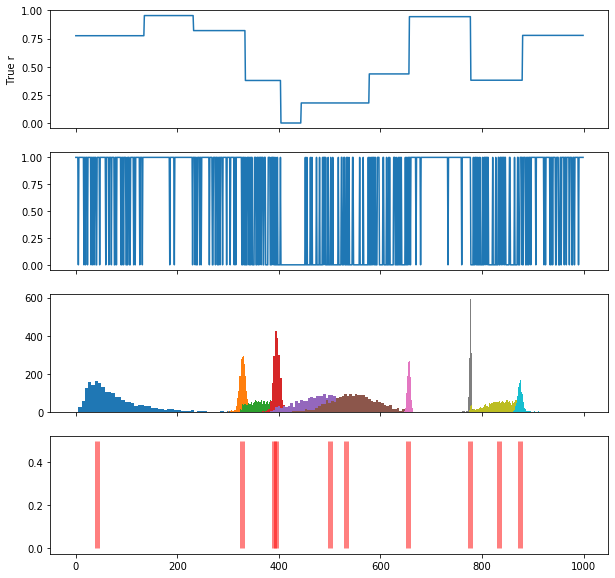

In [923]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
ax[0].plot(true_r)
ax[0].set_ylabel('True r')
ax[1].plot(data_vec)
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[3].vlines(mode_tau[tau_num],0,0.5,color='red',alpha=0.5,linewidth=5)
